# Data Reduction
In this activity, you will be reducing the data we took last week. In this notebook, you will learn how to go from raw data taken on a telescope and create science ready images! 

By the end of this activity, you will be ready to create a pretty 3-color Red-Blue-Green (RGB) image like this one:

![image](rsw-0023-RGB.jpg)

Credit: Richard S. Wright Jr.

## 0. Required imports
In order to reduce our data, we will need to import a few handy packages with the following call:
- import reduction (reduction packages for Nickel 1-m)
- from astropy.io import fits (to open on image files)
- import matplotlib.pyplot as plt (to show our image files)
- import numpy as np (certain math functions)
- import shutil (helpful for moving files around)
- glob (good for grabbing lists of files in directories)

In [2]:
# required imports

import reduction
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import shutil
import glob

## 1. Overscan subtraction
An overscan region of the CCD chip that is not exposed to light. The overscan region keeps track of the *bias* level throughout the night; as a reminder, the *bias* is a zero second exposure which tells us how "bright" each pixel is without any light hitting the camera. For this reason, the overscan region it is a useful way to remove small variations in the bias level throughout the night. We must first remove these columns and apply an overscan subtraction before we begin on data reduction.

### We'll first look at our raw images to see the overscan region. Pick any file of interest and plot the image below. There are two overscan regions: one, near a bright column of *bad pixels* (we'll deal with these later) and a faint column to the right of the image. You may have to play around with the scaling of your image to see these.

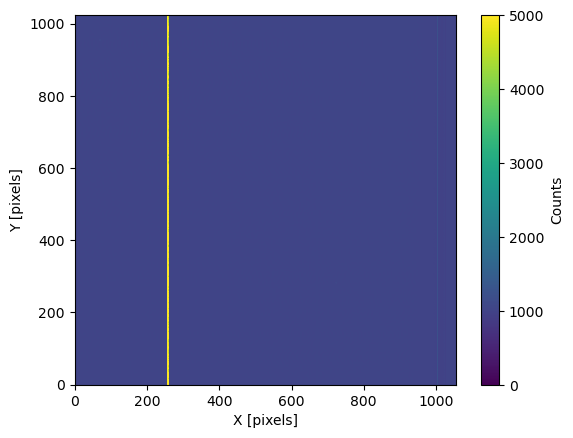

In [3]:
yourfile = './data-2023-06-27-nickel/raw/YOURFILEHERE' # put in your file here
data = fits.getdata(yourfile) # here, we read in the fits file using the astropy package and the getdata function

plt.imshow(data, origin='lower', vmin=0, vmax=1000) # change vmax (maximum count on scale) to change the scaling
plt.colorbar(label='Counts')
plt.xlabel('X [pixels]')
plt.ylabel('Y [pixels]')
plt.show()

### To perform the overscan subtraction, we will use the reduction package and call the function overscan_subtraction(*files*) which takes a list of raw files as an argument. In the following cell, we will create a list of all the data files and perform the overscan subtraction. 

Files that have been overscan subtracted will have an _os subscript. As a note, this may take a minute to run so as the cell is running, check out your raw directory. Do you see new files being created?

In [4]:
source_dir = './data-2023-06-27-nickel/raw/' # location of raw files
files = source_dir + '*.fits' # grabs all the files within this directory

reduction.overscan_subtraction(files)

### Check the overscan subtracted raw image from before. Are the overscan regions still there?

As a note, this image should end with _os.fits, meaning an overscan subtracted file. Both overscan columns should be gone (but the bright columns of bad pixels will remain).

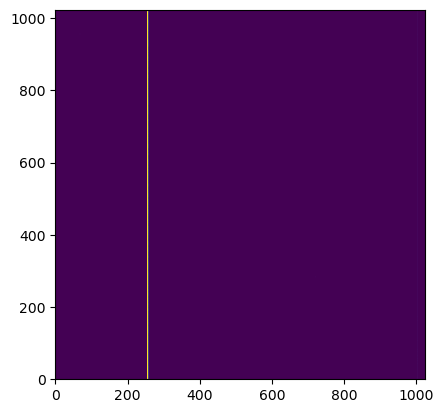

In [5]:
yourfile = './data-2023-06-27-nickel/raw/YOURFILEHERE' # put in your file here
data = fits.getdata(yourfile) # here, we read in the fits file using the astropy package

plt.imshow(data, origin='lower', vmin=0, vmax=9000) # adjust the scaling using vmax
plt.show()

## 2. Move files to correct directories
Having our overscan subtracted data, we can move our files to the correct directories for data reduction. In the data-2023-06-27-nickel directory, you should see a few different folders: 
- calibration, containing a folder named bias, halpha_flat, r_flat, v_flat, and flat; this folder will store our calibration files.
- raw; this folder stores our raw files + overscan subtracted
- science; this folder will store our science data

In this step, we will use the log to move each file into the correct folder. Write the corresponding file numbers for each type of file.

In [37]:
# put in the corresponding file numbers
bias_frames = range()
v_flat_frames = range()
r_flat_frames = range()
b_flat_frames = range()
halpha_flat_frames = range()
science_frames = range()

# makes a list of all the files using the range you gave above
v_flat_files = ['{0}d{1}_os.fits'.format(source_dir, num) for num in v_flat_frames]
b_flat_files = ['{0}d{1}_os.fits'.format(source_dir, num) for num in b_flat_frames]
r_flat_files = ['{0}d{1}_os.fits'.format(source_dir, num) for num in r_flat_frames]
halpha_flat_files = ['{0}d{1}_os.fits'.format(source_dir, num) for num in halpha_flat_frames]
bias_files = ['{0}d{1}_os.fits'.format(source_dir, num) for num in bias_frames]
science_files = ['{0}d{1}_os.fits'.format(source_dir, num) for num in science_frames]

# copy over each file into the correct directory
for file in v_flat_files:
    shutil.copy2(file, './data-2023-06-27-nickel/calibration/v_flat')

for file in b_flat_files:
    shutil.copy2(file, './data-2023-06-27-nickel/calibration/b_flat')

for file in halpha_flat_files:
    shutil.copy2(file, './data-2023-06-27-nickel/calibration/halpha_flat')

for file in r_flat_files:
    shutil.copy2(file, './data-2023-06-27-nickel/calibration/r_flat')

for file in bias_files:
    shutil.copy2(file, './data-2023-06-27-nickel/calibration/bias')

for file in science_files:
    shutil.copy2(file, './data-2023-06-27-nickel/science')

## 3. Create Master bias
As we said before, the *bias* is a zero second exposure that characterizes the behavoir of our detector when it's not exposed to light; each pixel will have a slightly different bias value. Although the bias level tends to be small, we must remove these extra pixel counts so they don't contribute to our image. To do this, we median combine our bias frames to create a *master bias*. We will then subtract this bias from all images taken with a non-zero exposure, or, our science images and our flats.

In [38]:
bias_path = './data-2023-06-27-nickel/calibration/bias/'
bias_files = glob.glob(bias_path+'*_os.fits')
data_stack = []

# create a list of bias frames 
for frame in bias_files:
    data_stack.append(fits.getdata(frame))

# Median combine the bias files to create the master bias frame
medianBias = np.median(data_stack, axis=0)

# Write out the master bias file (bias.fits) with updated FITS header information
header = fits.getheader(bias_files[0])
header['HISTORY'] = 'Median combined'
fits.writeto(bias_path+'bias.fits',medianBias,header,overwrite=True)  

### Let's open our master bias, which we bias.fits and svaed in the calibration/bias folder. What is the average count level in this bias frame? Is this a small or large value compared to the total number of counts that a single pixel can have (around ~65,000)?

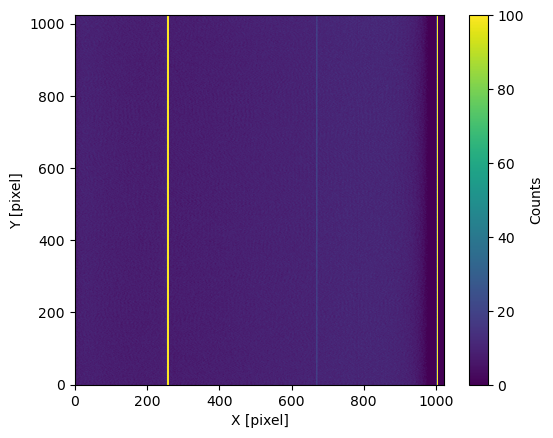

In [39]:
yourbias = './data-2023-06-27-nickel/calibration/bias/YOURBIAS' 
data = fits.getdata(yourbias) # here, we read in the fits file using the astropy package

plt.imshow(data, origin='lower', vmin=0, vmax=100) # adjust the scaling using vmax
plt.colorbar(label='Counts')
plt.xlabel('X [pixel]')
plt.ylabel('Y [pixel]')
plt.show()

## 4. Bias subtract all frames
Because the bias is in all frames, we must remove it from both our flats frames and our science frames before we can do anything else. I will show an example of how to do this for some of the flat frames (just the b flats), your job will be to do it for the rest of the files. As a note, the bias subtracted frames will be denoted by a _bs.fits to highlight that this frame has had the bias removed already. When you run your cells, check that your bias subtracted files are created.

### Bias subtract flat frames

In [40]:
# EXAMPLE WITH B_FLAT
# Bias subtracting the b_flat frames
# Make list of input files
datafilesin = glob.glob('./data-2023-06-27-nickel/calibration/b_flat/*_os.fits') # change from b_flat to filter your need or science

# _bs stands for bias subtracted in the output file names
datafilesout = [i[:-5]+ '_bs.fits' for i in datafilesin]

n = len(datafilesin)

# for each flat in the list b_flat, will bias subtract it
for i in range(0,n):
    data,header = fits.getdata(datafilesin[i],header=True)
    dataout = data - medianBias
    header['HISTORY'] = 'Bias subtracted'
    fits.writeto(datafilesout[i],dataout,header,overwrite=True)

########

# Bias subtracting the r_flat frames
datafilesin = glob.glob('./data-2023-06-27-nickel/calibration/YOURFLATFOLDERHER/*_os.fits') # change from b_flat to filter your need or science

# _bs stands for bias subtracted in the output file names
datafilesout = [i[:-5]+ '_bs.fits' for i in datafilesin]

n = len(datafilesin)

# for each flat in the list b_flat, will bias subtract it
for i in range(0,n):
    data,header = fits.getdata(datafilesin[i],header=True)
    dataout = data - medianBias
    header['HISTORY'] = 'Bias subtracted'
    fits.writeto(datafilesout[i],dataout,header,overwrite=True)

########

# Bias subtracting the halpha_flat
datafilesin = glob.glob('./data-2023-06-27-nickel/calibration/YOURFLATFOLDERHER/*_os.fits') # change from b_flat to filter your need or science

# _bs stands for bias subtracted in the output file names
datafilesout = [i[:-5]+ '_bs.fits' for i in datafilesin]

n = len(datafilesin)

# for each flat in the list b_flat, will bias subtract it
for i in range(0,n):
    data,header = fits.getdata(datafilesin[i],header=True)
    dataout = data - medianBias
    header['HISTORY'] = 'Bias subtracted'
    fits.writeto(datafilesout[i],dataout,header,overwrite=True)

######## 

# Bias subtracting the v_flat
datafilesin = glob.glob('./data-2023-06-27-nickel/calibration/YOURFLATFOLDERHER/*_os.fits') # change from b_flat to filter your need or science

# _bs stands for bias subtracted in the output file names
datafilesout = [i[:-5]+ '_bs.fits' for i in datafilesin]

n = len(datafilesin)

# for each flat in the list b_flat, will bias subtract it
for i in range(0,n):
    data,header = fits.getdata(datafilesin[i],header=True)
    dataout = data - medianBias
    header['HISTORY'] = 'Bias subtracted'
    fits.writeto(datafilesout[i],dataout,header,overwrite=True)

### Bias subtract science frames

In [41]:
# Bias subtracting the science frames

# Make list of input files
datafilesin = glob.glob('./data-2023-06-27-nickel/YOURSCIENCEDIRECTORYHERE/*_os.fits') # put in the name of the science directory

# _bs stands for bias subtracted in the output file names
datafilesout = [i[:-5]+ '_bs.fits' for i in datafilesin]

n = len(datafilesin)
for i in range(0,n):
    data,header = fits.getdata(datafilesin[i],header=True)
    dataout = data - medianBias
    header['HISTORY'] = 'Bias subtracted'
    fits.writeto(datafilesout[i],dataout,header,overwrite=True)

## 5. Create normalized flat-field for each filter
In an ideal system, each pixel would respond the same if the CCD is illuminated uniformly. In reality, though, each pixel has a different response and sensitivity to light, and this response changes filter to filter. A flat-field removes this behavior and divides out the uneven response.

### To see the importance of flat-fielding, let's first plot a bias subtracted science frame. Choose any and plot it below. Do you see anything weird about this frame (spots, donuts, dark spots)?

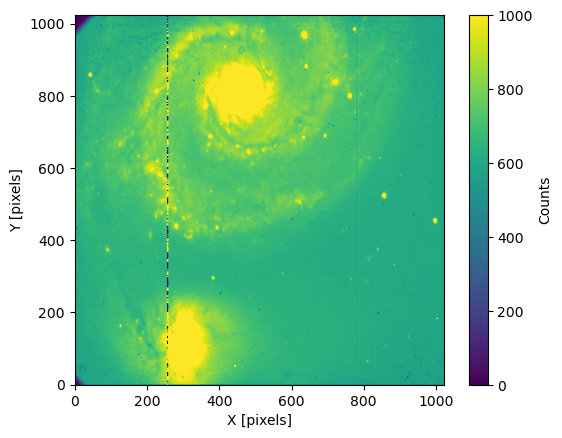

In [42]:
yourfile = './data-2023-06-27-nickel/science/YOURFILEHERE' # put in your file here
data = fits.getdata(yourfile) # here, we read in the fits file using the astropy package

plt.imshow(data, origin='lower', vmin=0, vmax=1000) # change scaling with vmax
plt.colorbar(label='Counts')
plt.xlabel('X [pixels]')
plt.ylabel('Y [pixels]')
plt.show()

### Now let's create our flats for each filter 
Here, you'll create a *normalized* (i.e. all the values are between 0 and 1) flat-field for each filter: B, R, V, and H-alpha. I'll do the first for you (B) and you'll complete the rest. These files will be saved in the /calibration/flats folder.

In [43]:
# EXAMPLE WITH B FLAT
# Create the master b_flat (bflat.fits)

b_flist = glob.glob('./data-2023-06-27-nickel/calibration/b_flat/*_bs.fits')
bflat_stack = []

# Read in each file and normalize by the median
for file in b_flist:
    data, header = fits.getdata(file,header=True) # read in the flat file data
    data = data / np.median(data) 
    bflat_stack.append(data)

# Median combine the flat fields, then normalize by the mean    
bflat = np.median(bflat_stack, axis=0)
m = np.mean(bflat)
bflat = bflat/m
header['HISTORY'] = 'Combined and normalized flat field'
fits.writeto('./data-2023-06-27-nickel/calibration/flats/' + 'bflat.fits',bflat,header,overwrite=True) 

###### 

# create the master r_flat (rflat.fits)

r_flist = glob.glob('./data-2023-06-27-nickel/calibration/YOURFILTERHERE/*_bs.fits')
rflat_stack = []

# Read in each file and normalize by the median
for file in r_flist:
    data, header = fits.getdata(file,header=True) # read in the flat file data
    data = data / np.median(data) 
    rflat_stack.append(data)

# Median combine the flat fields, then normalize by the mean    
rflat = np.median(rflat_stack, axis=0)
m = np.mean(rflat)
rflat = rflat/m
header['HISTORY'] = 'Combined and normalized flat field'
fits.writeto('./data-2023-06-27-nickel/calibration/flats/' + 'YOURFLATNAME.fits',rflat,header,overwrite=True)

###### 

# create the master halpha_flat (halphaflat.fits)

halpha_flist = glob.glob('./data-2023-06-27-nickel/calibration/YOURFILTERHERE/*_bs.fits')
halphaflat_stack = []

# Read in each file and normalize by the median
for file in halpha_flist:
    data, header = fits.getdata(file,header=True) # read in the flat file data
    data = data / np.median(data) 
    halphaflat_stack.append(data)

# Median combine the flat fields, then normalize by the mean    
halphaflat = np.median(halphaflat_stack, axis=0)
m = np.mean(halphaflat)
halphaflat = halphaflat/m
header['HISTORY'] = 'Combined and normalized flat field'
fits.writeto('./data-2023-06-27-nickel/calibration/flats/' + 'YOURFLATNAME.fits',halphaflat,header,overwrite=True)

###### 

# create the master v_flat (halphaflat.fits)

v_flist = glob.glob('./data-2023-06-27-nickel/calibration/YOURFILTERHERE/*_bs.fits')
vflat_stack = []

# Read in each file and normalize by the median
for file in v_flist:
    data, header = fits.getdata(file,header=True) # read in the flat file data
    data = data / np.median(data) 
    vflat_stack.append(data)

# Median combine the flat fields, then normalize by the mean    
vflat = np.median(vflat_stack, axis=0) 
m = np.mean(vflat)
vflat = vflat/m
header['HISTORY'] = 'Combined and normalized flat field'
fits.writeto('./data-2023-06-27-nickel/calibration/flats/' + 'YOURFLATNAME.fits',vflat,header,overwrite=True)

### Let's look at one of the flat-fields we created. Do you see the pixel-by-pixel response change?

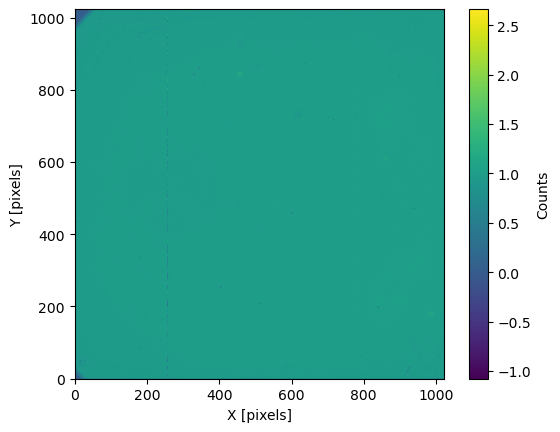

In [51]:
yourflat = './data-2023-06-27-nickel/calibration/flats/YOURFILEHERE.fits' # put in your file here
data = fits.getdata(yourflat) # here, we read in the fits file using the astropy package

plt.imshow(data, origin='lower',vmin=0, vmax=1000)
plt.colorbar(label='Counts')
plt.xlabel('X [pixels]')
plt.ylabel('Y [pixels]')
plt.show()

## 6. Flat-field science frames
Now that we have our flat frames we can flat-field our science frames. Choose one of the following objects to make a three color image of:
- M51 (Whirlpool Galaxy)
- M57 (Ring nebula)
- NGC5634 (globular cluster)

First, let's plot the science frames, before flat-fielding for our object. As a note, not all objects will have all 4 filters. 
### Looking at the log, figure out what frame corresponds to each filter four your object and plot it. Play around with the scaling if you find it hard to see features.

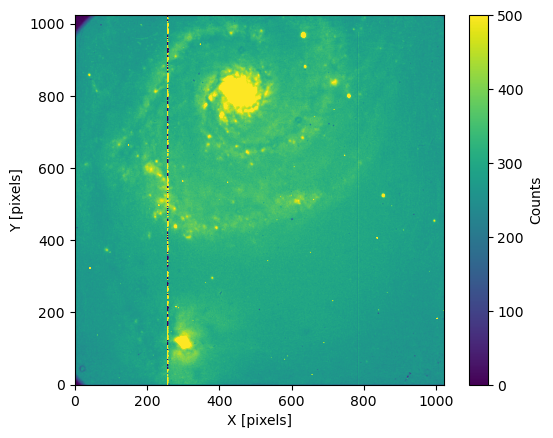

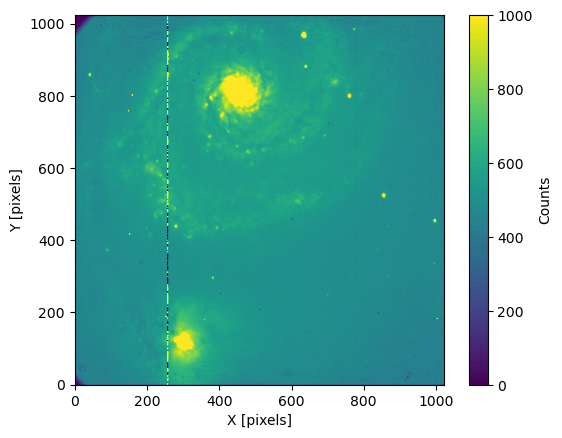

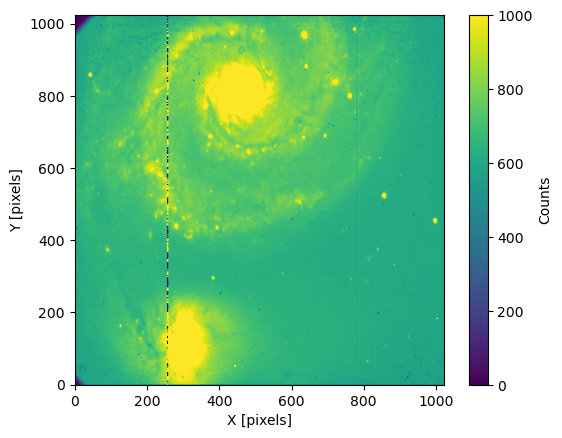

In [45]:
# B filter
yourfilt1 = './data-2023-06-27-nickel/science/YOURFILENUMBERHERE' # put in your file here
data1 = fits.getdata(yourfilt1) # here, we read in the fits file using the astropy package

plt.imshow(data1, origin='lower', vmin=0, vmax=500)
plt.colorbar(label='Counts')
plt.xlabel('X [pixels]')
plt.ylabel('Y [pixels]')
plt.show()

# V filter
yourfilt2 = './data-2023-06-27-nickel/science/YOURFILENUMBERHERE' # put in your file here
data2 = fits.getdata(yourfilt2) # here, we read in the fits file using the astropy package

plt.imshow(data2, origin='lower', vmin=0, vmax=1000)
plt.colorbar(label='Counts')
plt.xlabel('X [pixels]')
plt.ylabel('Y [pixels]')
plt.show()

# R filter
yourfilt3 = './data-2023-06-27-nickel/science/YOURFILENUMBERHERE' # put in your file here
data3 = fits.getdata(yourfilt3) # here, we read in the fits file using the astropy package

plt.imshow(data3, origin='lower', vmin=0, vmax=1000)
plt.colorbar(label='Counts')
plt.xlabel('X [pixels]')
plt.ylabel('Y [pixels]')
plt.show()

### Next, we can flat-field each of our frames using the flats we made above. 
The flat-fielded frame will be named as _ff to mark that it's been flat-fielded.

In [46]:
# B filter

# _ff stand for flat fielded for the output file name
bdataout = [i[:-5]+ '_ff.fits' for i in ['./data-2023-06-27-nickel/science/YOURBFILEHERE']]
b_flist = ['./data-2023-06-27-nickel/science/YOURBFILEHERE']

# For each file in list, divide by the normalize flat field frame for that filter
n=len(b_flist)
for i in range(0,n):
    data,header = fits.getdata(b_flist[i],header=True)
    dataout = data / bflat
    header['HISTORY'] = 'Flat Fielded'
    fits.writeto(bdataout[i],dataout,header,overwrite=True)

# V filter

# _ff stand for flat fielded for the output file name
vdataout = [i[:-5]+ '_ff.fits' for i in ['./data-2023-06-27-nickel/science/YOURVFILEHERE']]
v_flist = ['./data-2023-06-27-nickel/science/YOURVFILEHERE']

# For each file in list, divide by the normalize flat field frame for that filter
n=len(v_flist)
for i in range(0,n):
    data,header = fits.getdata(v_flist[i],header=True)
    dataout = data / vflat
    header['HISTORY'] = 'Flat Fielded'
    fits.writeto(vdataout[i],dataout,header,overwrite=True)

# R filter

# _ff stand for flat fielded for the output file name
rdataout = [i[:-5]+ '_ff.fits' for i in ['./data-2023-06-27-nickel/science/YOURRFILEHERE']]
r_flist = ['./data-2023-06-27-nickel/science/YOURRFILEHERE']

# For each file in list, divide by the normalize flat field frame for that filter
n=len(r_flist)
for i in range(0,n):
    data,header = fits.getdata(r_flist[i],header=True)
    dataout = data / rflat
    header['HISTORY'] = 'Flat Fielded'
    fits.writeto(rdataout[i],dataout,header,overwrite=True)

# HALPHA filter

# _ff stand for flat fielded for the output file name
halphadataout = [i[:-5]+ '_ff.fits' for i in ['./data-2023-06-27-nickel/science/YOURHALPHAFILEHERE']]
halpha_flist = ['./data-2023-06-27-nickel/science/YOURHALPHAFILEHERE']

# For each file in list, divide by the normalize flat field frame for that filter
n=len(halpha_flist)
for i in range(0,n):
    data,header = fits.getdata(halpha_flist[i],header=True)
    dataout = data / halphaflat
    header['HISTORY'] = 'Flat Fielded'
    fits.writeto(rdataout[i],dataout,header,overwrite=True)

/Users/zohaggard/opt/anaconda3/envs/astroconda37/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide


### Let's look at our science images again now that they're flat-fielded. What do you notice about them?

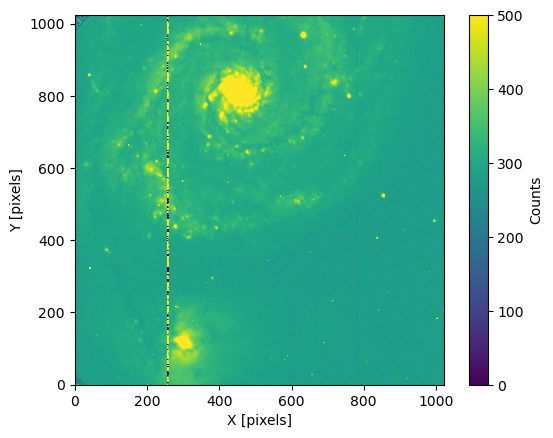

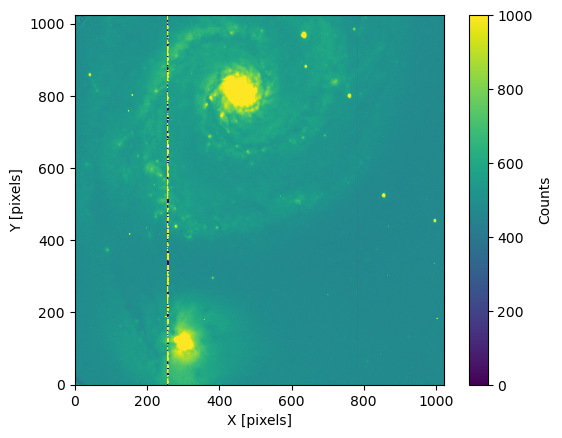

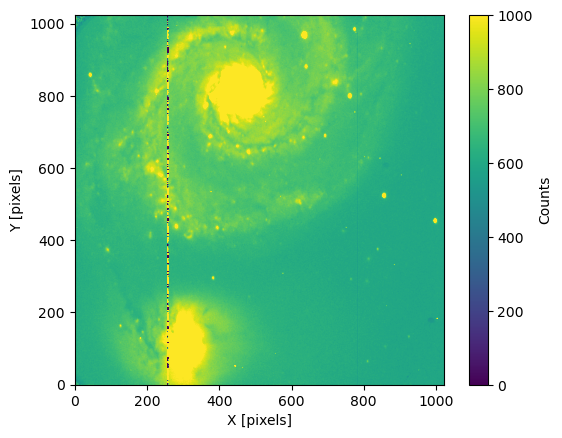

In [48]:
# B filter
yourfilt1 = './data-2023-06-27-nickel/science/YOURFILEHERE' # put in your file here
data1 = fits.getdata(yourfilt1) # here, we read in the fits file using the astropy package

plt.imshow(data1, origin='lower', vmin=0, vmax=500)
plt.colorbar(label='Counts')
plt.xlabel('X [pixels]')
plt.ylabel('Y [pixels]')
plt.show()

# V filter
yourfilt2 = './data-2023-06-27-nickel/science/YOURFILEHERE' # put in your file here
data2 = fits.getdata(yourfilt2) # here, we read in the fits file using the astropy package

plt.imshow(data2, origin='lower', vmin=0, vmax=1000)
plt.colorbar(label='Counts')
plt.xlabel('X [pixels]')
plt.ylabel('Y [pixels]')
plt.show()

# R filter
yourfilt3 = './data-2023-06-27-nickel/science/YOURFILEHERE' # put in your file here
data3 = fits.getdata(yourfilt3) # here, we read in the fits file using the astropy package

plt.imshow(data3, origin='lower', vmin=0, vmax=1000)
plt.colorbar(label='Counts')
plt.xlabel('X [pixels]')
plt.ylabel('Y [pixels]')
plt.show()

## 7. Bad pixel removal
The time has finally come ... we can remove that ugly column going through our data! We will use a bad pixel removal routine in the reduction package, called remove_bad_pixels(*files_in*, *files_out*), which takes a list of files in and files out. Essentially, this function looks for known bad columns in the Nickel 1-m CCD.

### Let's gather our flat-fielded science files and perform the bad-pixel subtraction 
Anything that has been bad-pixel subtracted will be marked with a _bp, meaning bad pixel.

In [49]:
files_in = glob.glob('./data-2023-06-27-nickel/science/*_ff.fits')
files_out = [file[:-5]+'_bp.fits' for file in files_in]

reduction.remove_bad_pixels(files_in, files_out)

/Users/zohaggard/Desktop/SOW_2023/data_reduction_activity/reduction.py:35: UserWarning: Warning: converting a masked element to nan.
  if np.math.isnan(mdata[i,j]):


### Now, plot your bad-pixel removed images. What do you notice?

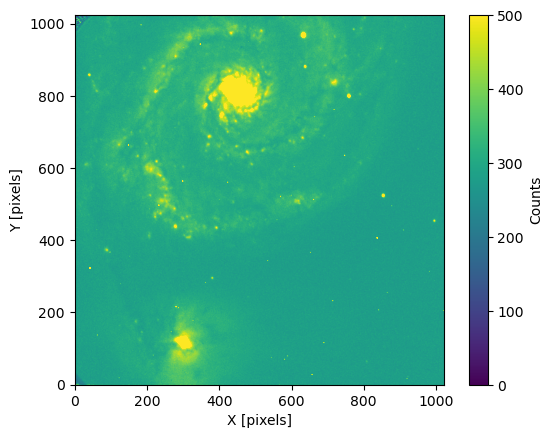

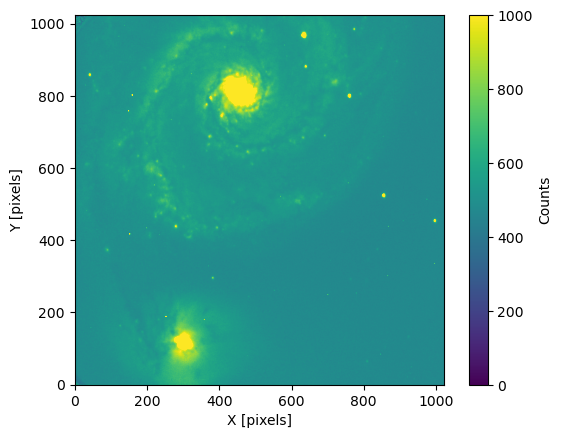

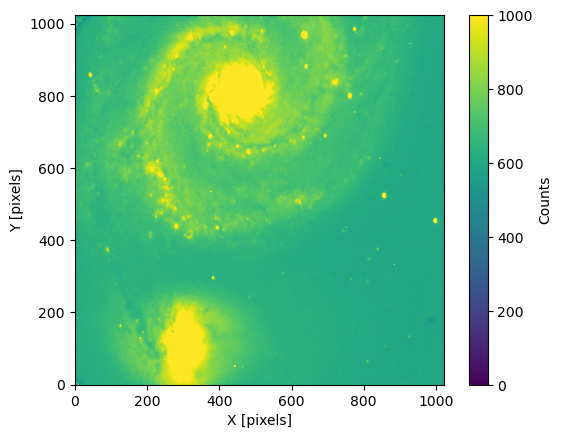

In [50]:
# B filter
yourfilt1 = './data-2023-06-27-nickel/science/YOURFILEHERE' # put in your file here
data1 = fits.getdata(yourfilt1) # here, we read in the fits file using the astropy package

plt.imshow(data1, origin='lower', vmin=0, vmax=500)
plt.colorbar(label='Counts')
plt.xlabel('X [pixels]')
plt.ylabel('Y [pixels]')
plt.show()

# V filter
yourfilt2 = './data-2023-06-27-nickel/science/YOURFILEHERE' # put in your file here
data2 = fits.getdata(yourfilt2) # here, we read in the fits file using the astropy package

plt.imshow(data2, origin='lower', vmin=0, vmax=1000)
plt.colorbar(label='Counts')
plt.xlabel('X [pixels]')
plt.ylabel('Y [pixels]')
plt.show()

# R filter
yourfilt3 = './data-2023-06-27-nickel/science/YOURFILEHERE' # put in your file here
data3 = fits.getdata(yourfilt3) # here, we read in the fits file using the astropy package

plt.imshow(data3, origin='lower', vmin=0, vmax=1000)
plt.colorbar(label='Counts')
plt.xlabel('X [pixels]')
plt.ylabel('Y [pixels]')
plt.show()

# 8. Creating an RGB image
You now are ready to create an RGB image using the data you just cleaned!
We will use a software called JS9 to create our images at this link: https://js9.si.edu

### First, load in all your cleaned frames. Go to the File tab and click 'open local'. Find each of your cleaned frames and upload them. They should begin to appear under the Images list.

![image](./js9/step2.png)

### Next, select the color tab. Go down and click the 'rgb mode' option as shown below

![image](./js9/step1.png)

### Now you can select which files correspond to Red, Green, and Blue. Click on an image using the File tab then select the Color tab. There, color options should appear. Choose Red, Blue, or Green depending on the filter of the image.
![image](./js9/step3.png)

### Your're all set! Now, just play around with the contrast on each filter by right clicking and draging your mouse around the image. By the end, you should end up with (hopefully a better looking) RGB image like this!
![image](./js9/rgb.png)